In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
df_cases = pd.read_csv("../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv")
df_death = pd.read_csv("../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv")

In [3]:
cases_id_vars = ['UID',
 'iso2',
 'iso3',
 'code3',
 'FIPS',
 'Admin2',
 'Province_State',
 'Country_Region',
 'Lat',
 'Long_',
 'Combined_Key']

death_id_vars = ['UID',
 'iso2',
 'iso3',
 'code3',
 'FIPS',
 'Admin2',
 'Province_State',
 'Country_Region',
 'Lat',
 'Long_',
 'Combined_Key',
 'Population']

In [4]:
df_cases_m = pd.melt(df_cases, id_vars=cases_id_vars)
df_cases_m["variable"] = pd.to_datetime(df_cases_m["variable"])
df_cases_m.rename(columns = {"variable": "date", "value": "num_cases"}, inplace=True)

df_death_m = pd.melt(df_death, id_vars=death_id_vars)
df_death_m["variable"] = pd.to_datetime(df_death_m["variable"])
df_death_m.rename(columns = {"variable": "date", "value": "num_death"}, inplace=True)

In [5]:
df_us = pd.merge(df_cases_m[["Province_State", "Admin2", "Combined_Key", "date", "num_cases"]],
                 df_death_m[["Province_State", "Admin2", "Combined_Key", "date", "Population", "num_death"]],
                 left_on = ["Province_State", "Admin2", "Combined_Key", "date"],
                 right_on =  ["Province_State", "Admin2", "Combined_Key", "date"])

In [6]:
df_us.head()

,Province_State,Admin2,Combined_Key,date,num_cases,Population,num_death
0,American Samoa,NaN,"American Samoa, US",2020-01-22,0,55641,0
1,Guam,NaN,"Guam, US",2020-01-22,0,164229,0
2,Northern Mariana Islands,NaN,"Northern Mariana Islands, US",2020-01-22,0,55144,0
3,Puerto Rico,NaN,"Puerto Rico, US",2020-01-22,0,2933408,0
4,Virgin Islands,NaN,"Virgin Islands, US",2020-01-22,0,107268,0


# Bay Area vs the rest analysis

https://www.sfchronicle.com/local-politics/article/Bay-Area-must-shelter-in-place-Only-15135014.php

First counties in Bay Area to institute "shelter in place" (SIP):

1. Marin
2. Contra Costa
3. Alameda
4. San Mateo
5. San Francisco
6. Santa Clara

In [7]:
df_CA = df_us[(df_us.Province_State == "California") & (df_us.Population > 0)].reset_index(drop=True)

sip_counties = ["Marin", 
                "Contra Costa", 
                "Alameda", 
                "San Mateo", 
                "San Francisco", 
                "Santa Clara"]

df_CA["SIP_start_date"] = "3/20/20"
df_CA.loc[df_CA.Admin2.isin(sip_counties), "SIP_start_date"] = "3/16/20"

Aggregate total number of cases and deaths grouped by the SIP start date:

In [8]:
df_sip_agged = df_CA.groupby(["SIP_start_date", "date"])[["num_cases", "num_death"]].sum().reset_index().sort_values("date")

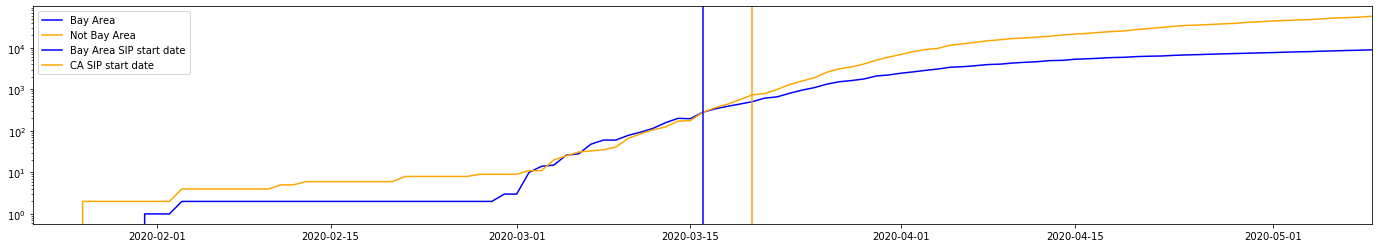

In [9]:
plt.figure(figsize=(24,4))
plt.semilogy(df_sip_agged[df_sip_agged.SIP_start_date == "3/16/20"]["date"], 
             df_sip_agged[df_sip_agged.SIP_start_date == "3/16/20"]["num_cases"], 
             label = "Bay Area", color = "blue")
plt.semilogy(df_sip_agged[df_sip_agged.SIP_start_date != "3/16/20"]["date"], 
             df_sip_agged[df_sip_agged.SIP_start_date != "3/16/20"]["num_cases"], 
             label = "Not Bay Area", color = "orange")
plt.axvline(pd.to_datetime("3/16/20"), color = "blue", label = "Bay Area SIP start date")
plt.axvline(pd.to_datetime("3/20/20"), color = "orange", label = "CA SIP start date")
plt.legend();
plt.xlim([df_sip_agged["date"].min(), df_sip_agged["date"].max()]);

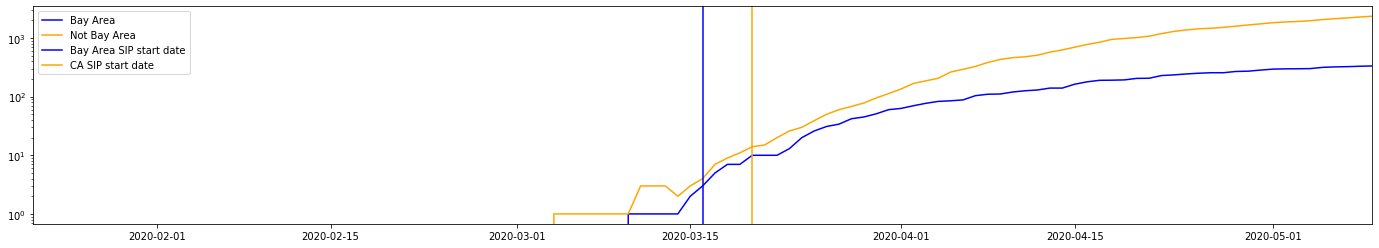

In [10]:
plt.figure(figsize=(24,4))
plt.semilogy(df_sip_agged[df_sip_agged.SIP_start_date == "3/16/20"]["date"], 
             df_sip_agged[df_sip_agged.SIP_start_date == "3/16/20"]["num_death"], 
             label = "Bay Area", color = "blue")
plt.semilogy(df_sip_agged[df_sip_agged.SIP_start_date != "3/16/20"]["date"], 
             df_sip_agged[df_sip_agged.SIP_start_date != "3/16/20"]["num_death"], 
             label = "Not Bay Area", color = "orange")
plt.axvline(pd.to_datetime("3/16/20"), color = "blue", label = "Bay Area SIP start date")
plt.axvline(pd.to_datetime("3/20/20"), color = "orange", label = "CA SIP start date")
plt.legend();
plt.xlim([df_sip_agged["date"].min(), df_sip_agged["date"].max()]);

# Visualize donor pool and Bay Area

We set the `decision_date` as the date of all information being available. We set this to be the day before the first SIP incidant of 3/16/2020.

In other words, 3/16/2020 SIP goes into place in the Bay Area but we treat our training set as anything from 3/15 to before. 3/16 could be used as a validation point. We aim to measure the impact of the treatment (SIP order) after 3/16; that is, we want to understand how the SIP order impacted the Bay Area the day after the SIP order onwards. 


We also consider only "relevant" counties that had more than `num_cases_thresh` of cases on the `decision_date`. From all these relevant counties, the `treatment_counties` are the counties that had the early SIP order on 3/16 whereas the `donor_counties` are all other counties that did not go into SIP until the state-wider order on 3/20. 

Our aim is to create a "synthetic control" of the `treatment_counties` from the pool of `donor_counties`.

In [11]:
decision_date = pd.to_datetime("3/16/20")
validation_date = pd.to_datetime("3/17/20")
num_cases_thresh = 5

relevant_counties = df_CA[(df_CA["date"] == decision_date) & (df_CA["num_cases"] >= num_cases_thresh)]["Admin2"].tolist()

donor_counties = list(set(relevant_counties) - set(sip_counties))

In [12]:
def plot_all_counties(df, counties):
    for county in counties:
        df_subset = df[(df["Admin2"] == county)]
        plt.semilogy(df_subset["date"], df_subset["num_cases"], color = "k", alpha = .1)
    #plt.xticks([])

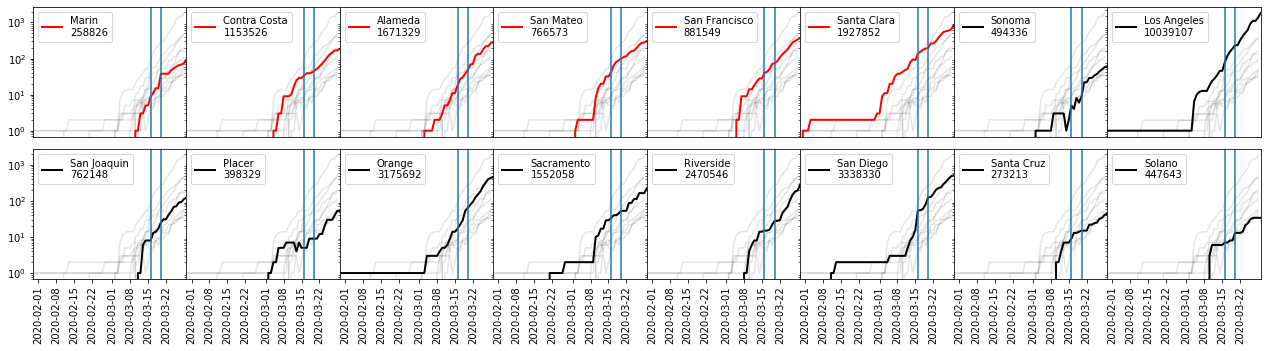

In [13]:
fig = plt.figure(figsize=(22,5))

    
for i, county in enumerate(sip_counties + donor_counties):

    plt.subplot(2,8, i+1)
    df_subset = df_CA[(df_CA["Admin2"] == county) & (df_CA["date"] <= pd.to_datetime("3/30/20"))]
    plot_all_counties(df_CA[df_CA["date"] <  pd.to_datetime("3/30/20")], donor_counties)
    if county in sip_counties:
        plt.semilogy(df_subset["date"], df_subset["num_cases"], color = "r", alpha = 1, linewidth = 2, 
                     label = county + "\n" + str(df_subset["Population"].iloc[0]))
    else:
        plt.semilogy(df_subset["date"], df_subset["num_cases"], color = "k", alpha = 1, linewidth = 2, 
                     label = county + "\n" + str(df_subset["Population"].iloc[0]))
    plt.axvline(decision_date)
    plt.axvline(pd.to_datetime("3/20/20"))

    plt.legend();
    if i < 8:
        plt.xticks([])
    else:
        plt.xticks(rotation = 90)
    if i%8 != 0:
        plt.yticks([])
    
    plt.subplots_adjust(hspace = .1, wspace = 0)
    plt.xlim([ pd.to_datetime("1/30/20"), pd.to_datetime("3/30/20")]);    

All the counties in the `treatment_counties` are in the Bay Area and we simply treat all of them as a single collective county. While there are many counties in the treatment_counties, their total population is comparable to other major counties in the `donor_counties`. 

In [14]:
df_donors_pop = df_CA[df_CA.Admin2.isin(donor_counties)][["Admin2", "Population"]].drop_duplicates()
df_treatment_pop = df_CA[df_CA.Admin2.isin(sip_counties)][["Admin2", "Population"]].drop_duplicates()

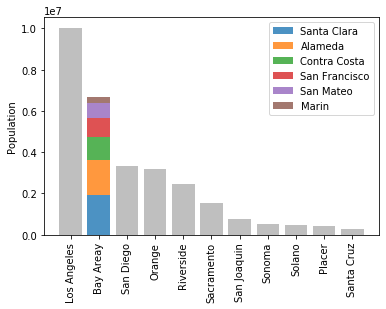

In [15]:
df_treatment_pop.sort_values("Population", ascending = False, inplace=True)
df_donors_pop.sort_values("Population", ascending = False, inplace=True)

r = list(set(list(range(df_donors_pop.shape[0] + 1))) - set([1]))
plt.bar(r, df_donors_pop.Population.sort_values(ascending=False), color = "grey", alpha = .5);
total = 0
for i in range(df_treatment_pop.shape[0]):
    plt.bar(1, df_treatment_pop.iloc[i,:]["Population"], bottom = total,
            label = df_treatment_pop.iloc[i,:]["Admin2"], alpha = .8)
    total += df_treatment_pop.iloc[i,:]["Population"]
plt.legend();
plt.ylabel("Population")
plt.xticks(range(11), ["Los Angeles", "Bay Areay"] + df_donors_pop["Admin2"].tolist()[1:], rotation = 90);




In [16]:
df_donor_pool = df_CA[df_CA.Admin2.isin(set(donor_counties) - set(sip_counties))].reset_index(drop=True)

df_treatment = df_CA[df_CA.Admin2.isin(sip_counties)].reset_index(drop=True)

df_bay_area = df_treatment[df_treatment["date"] <= pd.to_datetime("3/30/20")].groupby("date")[["num_cases"]].sum().reset_index()
df_bay_area["Population"] = df_treatment[["Admin2", "Population"]].drop_duplicates()["Population"].sum()

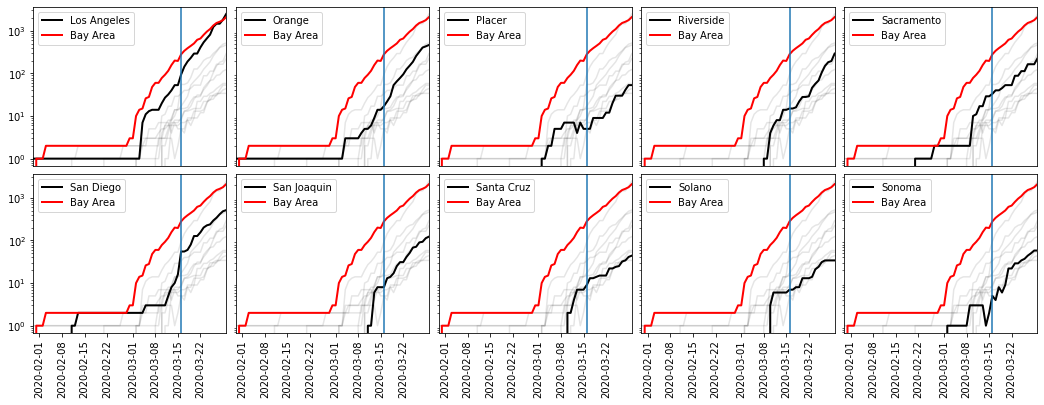

In [17]:
fig = plt.figure(figsize=(18,6))

    
for i, county in enumerate(pd.unique(df_donor_pool["Admin2"])):

    plt.subplot(2,5, i+1)
    plot_all_counties(df_donor_pool[df_donor_pool["date"] <=  pd.to_datetime("3/30/20")], pd.unique(df_donor_pool["Admin2"]))
    df_subset = df_donor_pool[(df_donor_pool["Admin2"] == county) & (df_donor_pool["date"] <= pd.to_datetime("3/30/20"))]
    plt.semilogy(df_subset["date"], df_subset["num_cases"], color = "k", alpha = 1, linewidth = 2, 
                     label = county)
    
    plt.semilogy(df_bay_area["date"], df_bay_area["num_cases"], color = "r", linewidth = 2, label = "Bay Area")
    plt.axvline(decision_date)
    #plt.axvline(pd.to_datetime("3/20/20"))

    #plt.semilogy(df_bay_area["variable"], df_bay_area["value"], color = "r", label = "Bay Area")
    plt.legend();
    if i < 5:
        plt.xticks([])
    else:
        plt.xticks(rotation = 90)
    if i%5 != 0:
        plt.yticks([])
    plt.subplots_adjust(hspace = .05, wspace = .05)
    plt.xlim([ pd.to_datetime("1/30/20"), pd.to_datetime("3/30/20")]);    